In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, sys, gc
import random
import math
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
from multiprocessing import cpu_count, current_process
import seaborn as sns
from datetime import datetime
from IPython.display import clear_output

In [4]:
import pickle
import feather
from imblearn.over_sampling import SMOTE
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
from lightgbm import LGBMClassifier
from kuma_utils.BearBoost import BearBoostStacking
from kuma_utils.ModelTuna import model_tuna, cross_validate
from kuma_utils.PreProcessing import *#adversarial_validation, target_encoding, KMeansFeaturizer, parallel_apply, thread_wrapper

/Users/CL4US/.pyenv/versions/finowcast/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/Users/CL4US/.pyenv/versions/finowcast/lib/python3.6/site-packages/chainer/_environment_check.py:37: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BL

In [5]:
# dir_data = '/mnt/gcs-bucket/kaggle/santander/'
dir_data = 'rawdata'

In [6]:
import warnings
warnings.filterwarnings('ignore')

# EDA

In [6]:
# train_data = pd.read_csv('rawdata/train.csv', index_col=0)
# test_data = pd.read_csv('rawdata/test.csv', index_col=0)

In [7]:
# train_data = train_data.astype(np.float32)
# train_data.target = train_data.target.astype(np.int8)
# train_data.to_hdf('rawdata/train.hdf', key='data')
# test_data = test_data.astype(np.float32)
# test_data.to_hdf('rawdata/test.hdf', key='data')

In [7]:
train_data = pd.read_hdf(os.path.join(dir_data, 'train.hdf'))
test_data = pd.read_hdf(os.path.join(dir_data, 'test.hdf'))
FEATURE_COL = test_data.columns

In [8]:
train1 = train_data.query('target == 1')
train0 = train_data.query('target == 0')
y = train_data['target']

In [9]:
train_data.head(10)

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
ID_code,,,,,,,,,,,,,,,,,,,,,
train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.522699,-2.3978,7.8784,8.5635,12.780300,-1.0914
train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.430500,2.0339,8.1267,8.7889,18.356001,1.9518
train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.604200,3.1417,-6.5213,8.2675,14.722200,0.3965
train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.034700,-1.2706,-2.9275,10.2922,17.969700,-8.9996
train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.287600,-1.5121,3.9267,9.5031,17.997400,-8.8104
train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,3.5855,...,-6.3068,6.6025,5.2912,0.4403,14.945200,1.0314,-3.6241,9.7670,12.580900,-4.7602
train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,-4.3781,...,8.7830,6.4521,3.5325,0.1777,18.331400,0.5845,9.1104,9.1143,10.886900,-3.2097
train_7,0,13.5580,-7.9881,13.8776,7.5985,8.6543,0.8310,5.6890,22.3262,5.0647,...,13.1700,6.5491,3.9906,5.8061,23.140699,-0.3776,4.2178,9.4237,8.662400,3.4806
train_8,0,16.1071,2.4426,13.9307,5.6327,8.8014,6.1630,4.4514,10.1854,-3.1882,...,1.4298,14.7510,1.6395,1.4181,14.837000,-1.9940,-1.0733,8.1975,19.511400,4.8453


In [11]:
train_data.shape, test_data.shape

((200000, 201), (200000, 200))

In [12]:
train_data.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

## Public/Private/Systhesized 

In [37]:
public_lb_idx = np.load(os.path.join(dir_data, 'public_LB.npy'))
private_lb_idx = np.load(os.path.join(dir_data, 'private_LB.npy'))
synthesized_idx = np.load(os.path.join(dir_data, 'synthetic_samples_indexes.npy'))

In [ ]:
train_unique45 = set(train_data['var_45'].unique())
test_unique45 = set(test_data['var_45'].unique())
print(len(train_unique45), len(test_unique45), len(train_unique45 & test_unique45))

In [ ]:
test_unique45_public = set(test_data.iloc[public_lb_idx]['var_45'].unique())
print(len(train_unique45), len(test_unique45_public), len(train_unique45 & test_unique45_public))

In [ ]:
test_unique45_private = set(test_data.iloc[private_lb_idx]['var_45'].unique())
print(len(train_unique45), len(test_unique45_private), len(train_unique45 & test_unique45_private))

In [ ]:
test_unique45_syn = set(test_data.iloc[synthesized_idx]['var_45'].unique())
print(len(train_unique45), len(test_unique45_syn), len(train_unique45 & test_unique45_syn))

## Visualize all variables

In [ ]:
plt.figure(figsize=(40, 125))
for i,col in enumerate(test_data.columns):
    ax = plt.subplot(25, 8, 1+i)
    sns.distplot(train_data[col])
#     sns.distplot(train1[col])
#     sns.distplot(train0[col])

In [ ]:
plt.figure(figsize=(40, 125))
for i,col in enumerate(test_data.columns):
    ax = plt.subplot(25, 8, 1+i)
    diff_hist = np.histogram(train_data[col].loc[train1.index], bins=100, density=True)[0] - \
                np.histogram(train_data[col].loc[train0.index], bins=100, density=True)[0]
    plt.plot(diff_hist)

In [622]:
# plt.figure(figsize=(40, 5))
# for i,col in enumerate(test_data.columns[0:10]):
#     sns.distplot(train_data[col])

In [11]:
def col_hist(cols=[]):
    for col in cols:
        ax = train_data.loc[train_data.target == 1, col].plot(label=1, kind='hist', histtype='step', 
                                                              alpha=0.5, density=True, bins=50)
        train_data.loc[train_data.target == 0, col].plot(ax=ax, label=0, kind='hist', histtype='step', 
                                                         alpha=0.5, density=True, bins=50)

In [46]:
trans_f.to_hdf(os.path.join(dir_data, 'trans_features.hdf'), key='data')

In [ ]:
_, adversarial_cols = ks_test_df(train_data, test_data)

In [ ]:
suspicious_cols, normal_cols = ks_test_df(train_data.query('target == 0'), train_data.query('target == 1'), plot=-1)

In [22]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [ ]:
plt.figure(figsize=(4/0, 125))
for i,col in enumerate(test_data.columns):
    ax = plt.subplot(25, 8, 1+i)
    sns.distplot(train_data[col].value_counts(normalize=True))

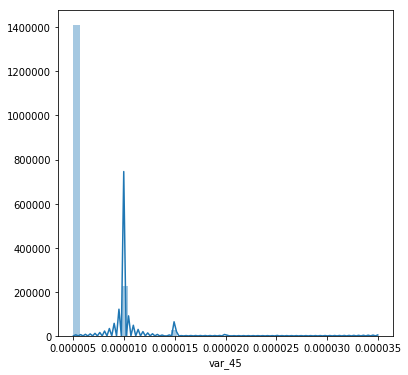

In [211]:
plt.figure(figsize=(6,6))
sns.distplot(train_data['var_45'].value_counts(normalize=True))

---
## Var_68

In [707]:
def agg_features(data, group_col='var_68'):
    new_features = pd.DataFrame()
    for idx, group in tqdm(data.groupby(group_col)):
        group = group.drop(group_col, axis=1)
        sns.distplot(group.loc[group['target'] == 1, 'var_12'])
        sns.distplot(group.loc[group['target'] == 0, 'var_12'])
#         tmp_features = pd.DataFrame()
#         for col in group.columns:
#             mean_col = np.mean(group[col])
#             tmp_features[col] = group[col] - mean_col
#         new_features = pd.concat([new_features, tmp_features])
        break
    return new_features

In [710]:
group = train_data.query('var_68 == 5.0214')

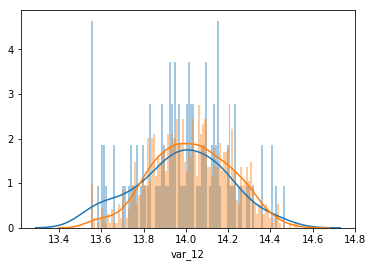

In [714]:
sns.distplot(group.loc[group['target'] == 1, 'var_12'], bins=100)
sns.distplot(group.loc[group['target'] == 0, 'var_12'], bins=100)

---
# Categorize variables

In [62]:
sc = StandardScaler()
normalized_train = pd.DataFrame(sc.fit_transform(train_data.drop('target', axis=1).values), 
                                columns=test_data.columns, index=train_data.index)

In [20]:
desc = normalized_train.describe()

In [46]:
normalized1 = normalized_train[train_data['target'] == 1]
normalized0 = normalized_train[train_data['target'] == 0]
desc1 = normalized1.describe()
desc0 = normalized0.describe()

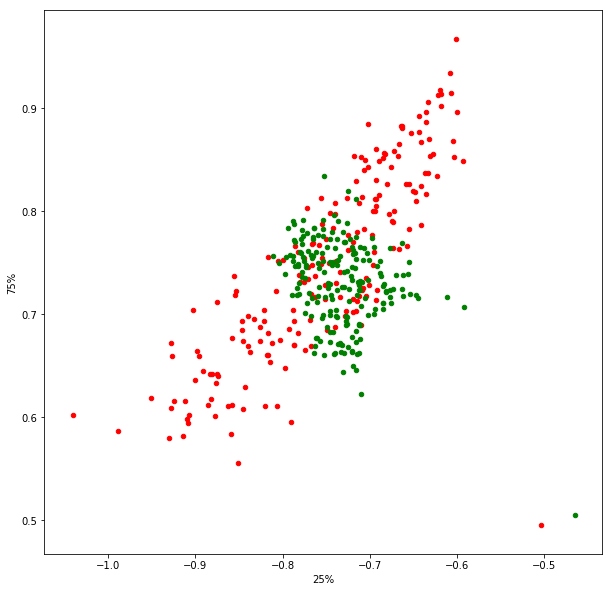

In [22]:
ax = desc1.T.plot(x='25%', y='75%', kind='scatter', figsize=(10,10), color='red')
desc0.T.plot(ax=ax, x='25%', y='75%', kind='scatter', figsize=(10,10), color='green')

---
# Random Vector

In [59]:
def get_angle(arr):
    x = arr[0:2]
    y = arr[2:]
    dot_xy = np.dot(x, y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    cos = dot_xy / (norm_x*norm_y)
    rad = np.arccos(cos)
    return rad

def randvec_features(data, y=None, n_vecs=20):
    new_features = pd.DataFrame()
    pos_idx = y[y == 1].index[0:9000]
    neg_idx = y[y == 0].index[0:1000]
    test_df = pd.concat([data.loc[pos_idx], data.loc[neg_idx]])
    test_y = pd.concat([y[pos_idx], y[neg_idx]])
    for seed in tqdm(range(n_vecs)):
        test_angle = test_df.sample(n=4, axis=1, random_state=seed)
        t_angle = test_angle.apply(lambda x: get_angle(x.values), axis=1)
        if y is not None:
            corr = np.corrcoef(t_angle, test_y)[0, 1]
#             print(corr)
            if corr > 0.05:
                print(test_angle.columns)
                print(corr)
                angle_df = data[test_angle.columns]
                new_features['vec_{}'.format(seed)] = angle_df.apply(lambda x: get_angle(x.values), axis=1)
    return new_features

In [111]:
# imp_cols = [81, 139, 12, 146, 76, 174, 21, 80, 166, 165, 13, 148, 198,
# 34, 115, 109, 44, 169, 149, 92, 108, 154, 33, 9, 192, 122, 121,
# 86, 123, 107, 127, 36, 172, 75, 177, 197, 87, 56, 93, 188, 131,
# 186, 141, 43, 104, 150, 31, 132, 23, 114, 58, 28, 116, 85, 194, 83]

# randvec_f = randvec_features(train_data.drop('target', axis=1).iloc[:, imp_cols], train_data['target'], 100)

In [63]:
randvec_f.to_hdf(os.path.join(dir_data, 'randvec_features.hdf'), key='data')

In [33]:
randvec_f['target'] = train_data['target']

---
# EM Algorithm

In [716]:
from sklearn.mixture import GaussianMixture as GMM
from scipy import signal

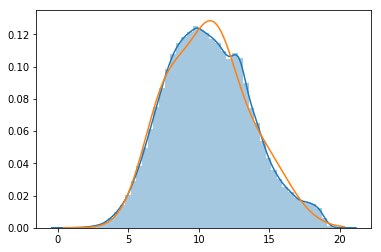

In [717]:
sns.distplot(train_data[['var_0']])
data = train_data[['var_0']].values.reshape(-1,1)
grid = np.linspace(data.min(), data.max(), num=1000)
gmm = GMM(n_components=3, reg_covar=0.01)
gmm.fit(data)
labels = gmm.score_samples(grid.reshape(-1,1))
plt.plot(grid, np.exp(labels))

In [718]:
def gmm_features(data):
    gmm=GMM(n_components=3, max_iter=100)
    new_features = pd.DataFrame()
    for col in tqdm(data.columns):
        if col == 'target':
            continue
        new_features['c_{}'.format(col)] = gmm.fit_predict(data[col].values.reshape(-1,1))
    new_features.index = data.index
    return new_features

In [206]:
gmm_f = gmm_features(train_data)

In [224]:
gmm_f#.to_hdf(os.path.join(dir_data, 'gmm_f.hdf'), key='data')

In [ ]:
reverse_list = [0,1,2,3,4,5,6,7,8,11,15,16,18,19,
                22,24,25,26,27,41,29,
                32,35,37,40,48,49,47,
                55,51,52,53,60,61,62,103,65,66,67,69,
                70,71,74,78,79,
                82,84,89,90,91,94,95,96,97,99,
                105,106,110,111,112,118,119,125,128,
                130,133,134,135,137,
                140,144,145,147,151,155,157,159,
                161,162,163,164,167,168,
                170,171,173,175,176,179,
                180,181,184,185,187,189,
                190,191,195,196,199]

In [128]:
def dist_plot(data, cols):
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    for col in cols:
        sns.distplot(data[col])
    plt.subplot(122)
    for col in cols:
        sns.distplot(data[col].value_counts())
    plt.show()

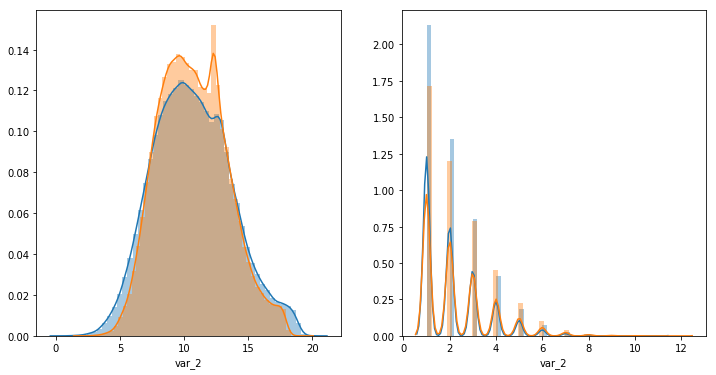

In [129]:
dist_plot(train_data, ['var_0', 'var_2'])

In [169]:
# ax = train_data[['var_13', 'var_123', 'var_80']].rank().sample(500).T.plot(figsize=(5,10), color='red', alpha=0.1)
# ax.get_legend().remove()

In [171]:
random_data = pd.DataFrame()
random_data[0] = np.random.normal(10, 5, 200000)
random_data[1] = np.random.normal(8, 7, 200000)
random_data[2] = np.random.normal(3, 7, 200000)
random_data = random_data.round(4)

In [170]:
# ax = random_data.rank().sample(500).T.plot(figsize=(5,10), color='r', alpha=0.1)
# ax.get_legend().remove()

In [172]:
# ax = train_data[['var_13', 'var_123', 'var_80']].diff(axis=1).iloc[:,1:].sample(500).T.plot(figsize=(5,10), color='r', alpha=0.1)
# ax.get_legend().remove()

In [173]:
# ax = random_data.diff(axis=1).iloc[:,1:].sample(500).T.plot(figsize=(5,10), color='r', alpha=0.1)
# ax.get_legend().remove()

In [213]:
def get_change(data, cols):
    diff = data[cols].diff(axis=1).diff(axis=1).iloc[:, 2]
    return diff

# Separate values according to their freq

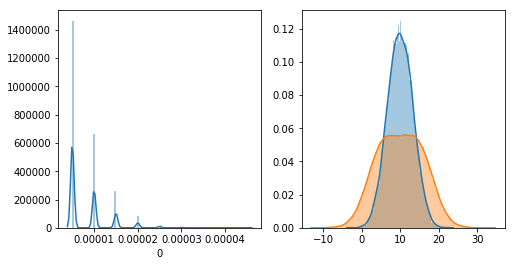

In [427]:
val_cnt = random_data[0].value_counts(normalize=True)
plt.figure(figsize=(8,4))
plt.subplot('121')
sns.distplot(val_cnt, bins=100)
plt.subplot('122')
val_cnt_r = pd.Series(val_cnt.index.values, index=val_cnt)
sns.distplot(val_cnt_r[val_cnt_r.index > np.median(val_cnt.unique())/2], bins=100)
sns.distplot(val_cnt_r[val_cnt_r.index <= np.median(val_cnt.unique())/2], bins=100)

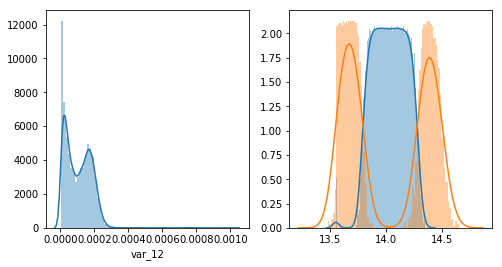

In [421]:
val_cnt = train_data['var_12'].value_counts(normalize=True)
plt.figure(figsize=(8,4))
plt.subplot('121')
val_cnt_r = pd.Series(val_cnt.index.values, index=val_cnt)
sns.distplot(val_cnt, bins=100)
plt.subplot('122')
sns.distplot(val_cnt_r[val_cnt_r.index > np.median(val_cnt.unique())/2], bins=100)
sns.distplot(val_cnt_r[val_cnt_r.index <= np.median(val_cnt.unique())/2], bins=100)

In [610]:
synthetic_cols = [6, 9, 12, 15, 23, 25, 27, 28, 34, 42, 43, 50, 53,
                 57, 59, 64, 66, 68, 71, 78, 79, 91, 93, 95, 98, 103,
                 105, 108, 111, 112, 114, 125, 130, 131, 132, 133, 144,
                 148, 153, 156, 161, 162, 166, 169, 181, 189, 197]
def separate_synthetic_dist(data, cols):
    new_features = pd.DataFrame()
    for icol in tqdm(cols):
        tmp = np.zeros(len(data))
        val_cnt = data.iloc[:, icol+1].value_counts(normalize=True)
        cutoff = np.median(val_cnt.unique())/2
        val_cnt_r = pd.Series(val_cnt.index.values, index=val_cnt)
        syn_vals = val_cnt_r[val_cnt_r.index > cutoff]
        val_range = (-1000, np.mean(syn_vals) - 1.5 * np.std(syn_vals), np.mean(syn_vals) + 1.5 * np.std(syn_vals), 10000)
        print(val_range)
#         tmp = np.abs(data.iloc[:, icol+1] - np.mean(syn_vals))
        tmp = pd.cut(data.iloc[:, icol+1], val_range, labels=False)
#         tmp = pd.cut(tmp, 3, labels=False)
        new_features['syn_{}'.format(icol)] = tmp
    return new_features

def val_counts(data, cols):
    new_features = pd.DataFrame()
    for icol in tqdm(cols):
#         val_cnt = data.iloc[:, icol+1].value_counts(normalize=True)
        freq, bins = np.histogram(data.iloc[:, icol+1], bins=data.iloc[:, icol+1].nunique(), density=True)
        bins[-1] = np.inf
        cut_value = pd.cut(data.iloc[:, icol+1], bins, labels=False, right=False)
        new_features['cnt_{}'.format(icol)] = cut_value.apply(lambda x: freq[int(x)])
    return new_features

def val_counts2(data, cols):
    new_features = pd.DataFrame()
    for icol in tqdm(cols):
        val_cnt = data.iloc[:, icol+1].value_counts(normalize=True).to_dict()
        new_features['cnt_{}'.format(icol)] = data.iloc[:, icol+1].replace(val_cnt)
    return new_features

In [689]:
def shuffle_col(data, cols):
    new_features = pd.DataFrame(index=data.index)
    for icol in tqdm(cols):
        tmp_data = data.iloc[:, icol+1].copy()
        break_point = tmp_data.median()
        first_part =  tmp_data[tmp_data < break_point].copy()
        second_part =  tmp_data[tmp_data >= break_point].copy()
        first_part = pd.Series(np.random.permutation(first_part.values), first_part.index)
        second_part = pd.Series(np.random.permutation(second_part.values), second_part.index)
        new_data = pd.concat([first_part, second_part])
        new_data.name = 'sfl_{}'.format(icol)
        new_features = pd.merge(new_features, new_data, left_index=True, right_index=True)
    return new_features

In [705]:
# syn_f = separate_synthetic_dist(train_data, cols=[12, 15, 23, 25, 24, 43, 68, 71, 91, 
#                                                   103, 125, 131, 133, 148, 161, 166, 169,])
# cnt_f = val_counts(train_data, cols=[12, 15, 23, 25, 24, 43, 68, 71, 91, 
#                                                   103, 125, 131, 133, 148, 161, 166, 169,])
# sfl_f = shuffle_col(train_data, np.random.randint(0, 199, 5))

In [765]:
y.loc[syn_f['syn_12'] == 0].value_counts()

0    23447
1     4240
Name: target, dtype: int64

In [595]:
cnt_f.to_hdf(os.path.join(dir_data, 'cnt_f.hdf'), key='data')#.iloc[:,0].value_counts()

# Counter distribution of peaks

In [141]:
def extract_peak_id(data, plot=True):
    if plot:
        sns.distplot(data, bins=1000)
    freq, bins = np.histogram(data, bins=1000)
#     peaks = signal.find_peaks(freq, prominence=thres)
    peak = np.argmax(freq)
#     print(freq)
    print(peak)
    print(bins[peak])
    return (bins[peak] < data) & (data < bins[peak+1])

98
13.55415


0    1144
1     363
Name: target, dtype: int64

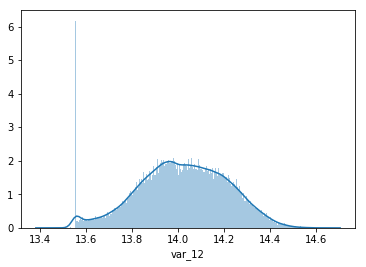

In [121]:
y.loc[extract_peak_id(train_data['var_12'])].value_counts()

588
12.251809


0    490
1     84
Name: target, dtype: int64

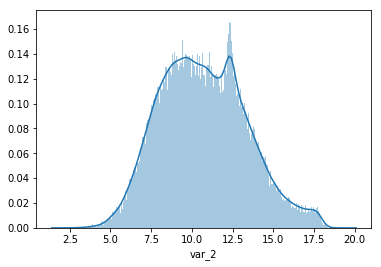

In [122]:
y.loc[extract_peak_id(train_data['var_2'])].value_counts()

585
10.7646675


0    633
1     63
Name: target, dtype: int64

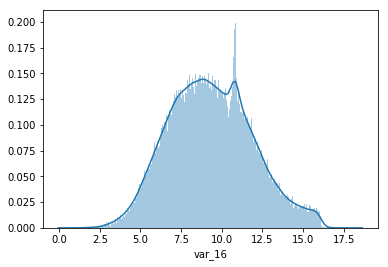

In [124]:
y.loc[extract_peak_id(train_data['var_16'])].value_counts()

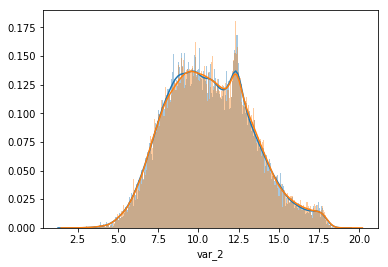

In [16]:
sns.distplot(train_data['var_2'].iloc[0:100000], bins=1000)
sns.distplot(train_data['var_2'].iloc[100000:], bins=1000)
# sns.distplot(train_data['var_16'], bins=1000)

In [18]:
train_data.iloc[100000:, 0].value_counts()

0    89917
1    10083
Name: target, dtype: int64

98
13.55415


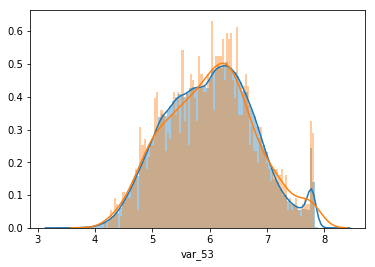

In [761]:
sns.distplot(train_data['var_53'], bins=100)
sns.distplot(train_data.loc[extract_peak_id(train_data['var_12'], plot=False), 'var_53'], bins=100)

In [744]:
peak_corr = train_data.loc[extract_peak_id(train_data['var_12'], plot=False)].corr()

98
13.55415


In [767]:
counter_dev = peak_val_13.describe().T['std']/basic_stats['std']

In [769]:
np.abs(counter_dev).sort_values().head()

var_13     0.001803
var_161    0.934354
var_40     0.948581
var_39     0.950671
var_95     0.952689
Name: std, dtype: float64

# Unique values

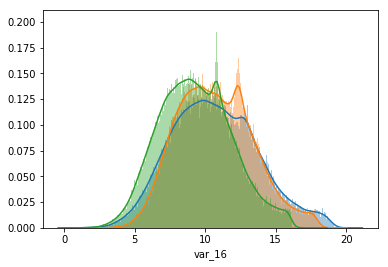

In [10]:
sns.distplot(train_data['var_0'], bins=1000)
sns.distplot(train_data['var_2'], bins=1000)
sns.distplot(train_data['var_16'], bins=1000)

In [11]:
common_val2 = list(set(train_data['var_0'].unique()) & set(train_data['var_2'].unique()))
common_val3 = list(set(train_data['var_0'].unique()) & set(train_data['var_2'].unique()) & set(train_data['var_16'].unique()))

In [12]:
common_val_0 = list(set(train0['var_0'].unique()) & set(train0['var_2'].unique()) & set(train0['var_16'].unique()))
common_val_1 = list(set(train1['var_0'].unique()) & set(train1['var_2'].unique()) & set(train1['var_16'].unique()))

In [13]:
unique_21 = train1['var_0'].unique()
unique_21.shape
# unique_22 = train1.iloc[10000:]['var_0'].unique()
# unique_21.shape, unique_22.shape, len(list(set(unique_21) & set(unique_22)))

(18473,)

In [14]:
train_data.loc[train_data['var_0'].isin(unique_21), 'target'].value_counts()

0    30108
1    20098
Name: target, dtype: int64

## ~~これか...！~~

In [15]:
sns.distplot(list(set(unique_21) & set(unique_22)))
sns.distplot(train1['var_0'])

NameError: name 'unique_22' is not defined

In [16]:
train_data.loc[train_data['var_0'].isin(common_val_1), 'target'].value_counts()

0    990
1    543
Name: target, dtype: int64

In [51]:
test_lb = test_data.iloc[np.concatenate([public_lb_idx, private_lb_idx])]
test_lb.loc[test_lb['var_0'].isin(common_val_1), 'var_0'].shape

(551,)

In [814]:
print(len(set(train_data['var_0'].unique())))
print(len(set(train_data['var_2'].unique())))
print(len(set(train_data['var_16'].unique())))
print(len(common_val2))
print(len(set(train_data['var_0'].unique()) & set(train_data['var_16'].unique())))
print(len(set(train_data['var_2'].unique()) & set(train_data['var_16'].unique())))
print(len(common_val3))

94672
86555
86918
66546
65251
63098
52141


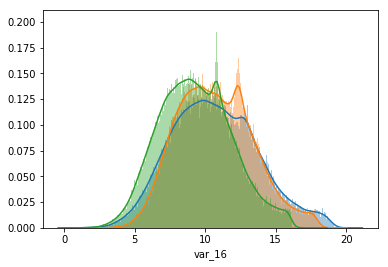

In [908]:
sns.distplot(train_data['var_0'], bins=1000)
sns.distplot(train_data['var_2'], bins=1000)
sns.distplot(train_data['var_16'], bins=1000)
# sns.distplot(common_val2, color='red', bins=1000)
# sns.distplot(common_val3, color='red', bins=1000)

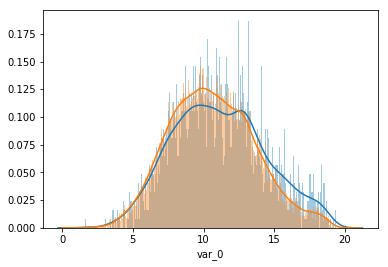

In [907]:
# sns.distplot(train_data.loc[~train_data['var_16'].isin(common_val3), 'var_0'], bins=1000)
sns.distplot(train_data.loc[~train_data['var_16'].isin(common_val3) & (train_data['target'] == 1), 'var_0'], bins=1000)
sns.distplot(train_data.loc[~train_data['var_16'].isin(common_val3) & (train_data['target'] == 0), 'var_0'], bins=1000)

In [21]:
train_data.loc[train_data['var_0'].isin(common_val3), 'target'].value_counts()

0    113677
1     11771
Name: target, dtype: int64

In [ ]:
train_data.loc[~train_data[''].isin(common_val3), 'target'].value_counts()

In [30]:
def common_value_features(data, value_list):
    new_features = pd.DataFrame()
    for col in tqdm(data.columns):
        if col == 'target':
            continue
        new_features['cmn_'+col] = data[col].isin(value_list).astype(np.int8)
    return new_features

In [31]:
cmn_f = common_value_features(train_data, common_val3)

In [37]:
cmn_f.to_hdf('rawdata/cmn_f.hdf', key='data')

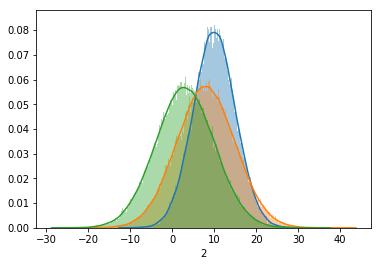

In [792]:
sns.distplot(random_data[0], bins=1000)
sns.distplot(random_data[1], bins=1000)
sns.distplot(random_data[2], bins=1000)

In [796]:
print(len(set(random_data[0].unique())))
print(len(set(random_data[1].unique())))
print(len(set(random_data[2].unique())))
print(len(set(random_data[1].unique()) & set(random_data[0].unique())))
print(len(set(random_data[2].unique()) & set(random_data[1].unique())))
print(len(set(random_data[2].unique()) & set(random_data[0].unique())))
print(len(set(random_data[2].unique()) & set(random_data[1].unique()) & set(random_data[0].unique())))

123026
139126
139410
68584
63751
54985
33268


In [864]:
def valcnt_features(data):
    new_features = pd.DataFrame()
    for col in tqdm(data.columns):
        if col == 'target':
            continue
        cnt = data[col].value_counts(normalize=True)
        new_features['cnt_'+col] = data[col].apply(lambda x: cnt[x])
    return new_features

def valcnt_features_mt(data):
    cnt = data.value_counts(normalize=True)
    return data.apply(lambda x: cnt[x])

In [857]:
cnt_f = valcnt_features(train_data)

In [871]:
cnt_f_test = parallel_apply(test_data.iloc[np.concatenate([public_lb_idx, private_lb_idx])], valcnt_features_mt, axis='columns')

thread_count: 8


In [859]:
# cnt_f.to_hdf('rawdata/cnt_f.hdf', key='data')

In [873]:
cnt_f_test.to_hdf('rawdata/cnt_f_test.hdf', key='data')